In [1]:
import numpy as np
import numpy.polynomial.legendre as leg
import scipy as sc
from scipy.stats import norm
from scipy import optimize as op
import math
import cmath
import matplotlib.pyplot as plt

# Pricing options via Fourier inversion

This notebook is a companion to the lecture given as part of the 11th Summer School in Mathematical Finance on the 21st of February 2018 at the African Insitute for Mathematical Sciences. In several exercises in this notebook you will learn how to use Python to price options via Fourier inversion in both the Black-Scholes and the Variance Gamma model.

## Black-Scholes model

First of all, we will define the Black-Scholes model. Each model in this notebook will have:
* A forward, implemented by the forward property
* A characteristic function, implemented by the char_func(u, maturity) function

The characteristic function routine uses the cmath module for complex arithmetic.

In [20]:
class BlackScholes:
    def __init__(self, forward, vol):
        self.forward = forward
        self._log_forward = math.log(forward)
        self.vol = vol

    def char_func(self, u, maturity):
        i = complex(0, 1)
        return cmath.exp(i * u * self._log_forward - 0.5 * self.vol * self.vol * maturity * u * (u + i)) 
    
    def forward_opt(self, strike, maturity):
        d1 = (math.log(self.forward / strike) + 0.5 * self.vol * self.vol * maturity) / (self.vol * math.sqrt(maturity))
        d2 = d1 - self.vol * math.sqrt(maturity)
        nd1 = norm.cdf(d1)
        nd2 = norm.cdf(d2)
        return self.forward * nd1 - strike * nd2

In addition the Black-Scholes model has a forward_opt function, which calculates the undiscounted (i.e. forward) price of a call option in the Black-Scholes model, using the closed-form expression. We can use this to compare whether what we calculate makes sense.

Later on when we will be comparing prices, it can be useful to compare them in terms of implied volatilities. For this we will use the following very crude implementation (only to be used for demonstration purposes):

In [21]:
def implied_vol_bs(forward, strike, maturity, price):
    func = lambda x: BlackScholes(forward, x).forward_opt(strike, maturity) - price
    root = op.root(func, 0.2)
    if root.success == False:
        raise Exception('Could not calculate implied volatility for option with (F, K, T, price): (' + \
                        str(forward) + ', ' + str(strike) + ', ' + str(maturity) + ', ' + str(price) + ')')
    return root.x[0]

To check that it works - we will first calculate the price of a Black-Scholes call, when forward is equal to 100.0, strike is equal to 125.0, implied volatility is equal to 40% and the maturity equals 5 years.

In [22]:
price = BlackScholes(forward=100.0, vol=0.4).forward_opt(strike=125.0,maturity=5.0)

The implied volatility is 40%, as expected:

In [23]:
implied_vol_bs(forward=100.0, strike=125.0, maturity=5.0, price=price)

0.40000000000000013

## Numerical integration

For this notebook we have chosen Gauss-Legendre quadratures for demonstration purposes. With the following function one can integrate a function (func) over the interval [a, b], using n abscissae:

In [24]:
def gauss_legendre_integrate(func, n, a, b):
    gauleg = leg.leggauss(n)
    gauleg_x = (gauleg[0] + 1) / 2 * (b-a) + a
    gauleg_w = gauleg[1] * (b-a)/2
    gauleg_x_w = zip(gauleg_x, gauleg_w)
    return sum(map(lambda x: func(x[0]) * x[1], gauleg_x_w))

To demonstrate its usage - the Gaussian density function, integrated over [-10, 10] should roughly be equal to 1.0:

In [25]:
gauss_legendre_integrate(lambda x: math.exp(-0.5 * x * x) / math.sqrt(2.0 * math.pi), 256, -10.0, 10.0)

1.0000000000000002

## First attempt at Fourier inversion - the Lévy / Gurland / Gil-Pelaez way

As shown in the lecture, one can generalise the Black-Scholes formula to calculate a call option as F * N(d1) - K * N(d2) to classes of models where the characteristic function is known. The following routine calculates the option price in this way, and takes a model as an argument.

In [26]:
def gil_pelaez_opt(model, strike, maturity, num_abscissae, integration_bound):
    log_strike = math.log(strike)
    i = complex(0, 1)
    phi_minus_i = complex(0, 1) * model.char_func(-i, maturity)
    s_func = lambda x: cmath.exp(-i * x * log_strike) * model.char_func(x - i, maturity) / (i * x * model.char_func(-i, maturity))
    s_prob = 0.5 + 1.0 / math.pi * gauss_legendre_integrate(s_func, num_abscissae, 0, integration_bound).real
    p_func = lambda x: cmath.exp(-i * x * log_strike) * model.char_func(x, maturity) / (i * x)
    p_prob = 0.5 + 1.0 / math.pi * gauss_legendre_integrate(p_func, num_abscissae, 0, integration_bound).real
    return model.forward * s_prob - strike * p_prob

Ideally we would like to avoid having to specify either the number of abscissae or an upper integration bound - as discussed in the lecture, adaptive integration routines together with an integral transformation can be used for this purpose. However, that goes to demonstrate in this short notebook.

To demonstrate that the routine works, we will evaluate the Black-Scholes option price using both this approach, as well as the closed-form formula provided in the BlackScholes class.

In [45]:
bs = BlackScholes(100.0, 0.4)
gil_pelaez_price = str(gil_pelaez_opt(model=bs,
                                      strike=125.0, maturity=5.0, num_abscissae=128, integration_bound=1000.0))
print("Gil-Pelaez price: " + str(gil_pelaez_price))
print("Closed-form price: "  +str(price))

Gil-Pelaez price: 27.462675786461375
Closed-form price: 27.462664357


## Exercise 1 - Fourier option pricing via Carr-Madan / Lewis formulation

Now you have seen how to implement the Gil-Pelaez transform, the first exercise is to implement the Carr-Madan / Lewis option pricing formula as featured in the slides of the lecture. The residue needed to use the Carr-Madan formula for non-positive values of alpha is already implemented below:

In [28]:
def residue(alpha, forward, strike):
    TOL = 2.2204460492503131e-16
    if alpha < -1.0:
        # Put
        return forward - strike
    if abs(alpha + 1.0) < TOL:
        # Half-cash secured put
        return forward - 0.5 * strike
    if alpha > -1.0 and alpha < 0.0:
        # Covered call
        return forward
    if abs(alpha) < TOL:
        # Half-covered call
        return 0.5 * forward
    if alpha > 0.0:
        # Call
        return 0.0

Please add the calculated price (or error in implied volatility if you want to change the metric) in the graph below. You can use an arbitrary choice of the damping factor alpha.

A: First of all, we have to implement the Carr-Madan / Lewis option pricing formula for arbitrary values of $\alpha$. This is achieved in the following routine:

In [39]:
def cm_lewis_opt(model, strike, maturity, num_abscissae, integration_bound, alpha):
    log_strike = math.log(strike)
    i = complex(0, 1)
    denominator = lambda v: -(v - i * alpha) * (v - i * (alpha + 1))
    integrand_func = lambda v: cmath.exp(-i * (v - i * alpha) * log_strike) * model.char_func(v - i * (alpha + 1), maturity) / denominator(v)
    integral = 1.0 / math.pi * gauss_legendre_integrate(integrand_func, num_abscissae, 0, integration_bound).real
    return residue(alpha, model.forward, strike) + integral

We check our implementation by verifying that it prices the Black-Scholes option correctly, for a value of $\alpha = -0.5$:

In [50]:
cm_lewis_opt(model=bs, strike=125.0, maturity=5.0, num_abscissae=128, integration_bound=1000.0,alpha=-0.5)

27.587811773521025

We can now easily insert it in the graph below:

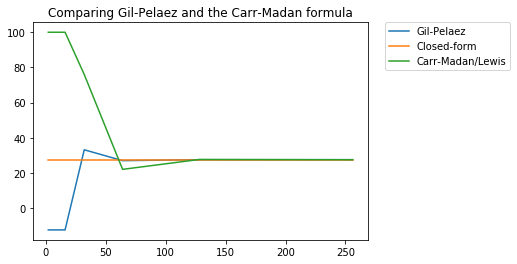

In [55]:
model = BlackScholes(100.0, 0.4)
abscissae_list = [2, 4, 8, 16, 32, 64, 128, 256]

gil_pelaez_prices = [gil_pelaez_opt(model=model,strike=125.0,maturity=5.0,num_abscissae=n,integration_bound=1000.0) for n in abscissae_list]
cm_lewis_prices = [cm_lewis_opt(model=model,strike=125.0,maturity=5.0,num_abscissae=n,integration_bound=1000.0,alpha=-0.5) for n in abscissae_list]
bs_prices = [price for n in abscissae_list]
plt.plot(abscissae_list, gil_pelaez_prices, label="Gil-Pelaez")
plt.plot(abscissae_list, bs_prices, label="Closed-form")
plt.plot(abscissae_list, cm_lewis_prices, label="Carr-Madan/Lewis")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Comparing Gil-Pelaez and the Carr-Madan formula")
plt.show()

For this choice of damping parameter, the Carr-Madan takes longer to get to the right price. But you can verify for yourself that for e.g. $\alpha = 0.75$, it gets there quicker. We will see the effect of the damping parameter in the next exercise.

## Variance Gamma model

Before we move on to the next exercise, we will need the Variance Gamma model. Below we have introduced another model class that follows the same structure outlined before - the model has a char_func function that returns its characteristic function. Therefore we should be able to use it with all option prices introduced so far.

In [56]:
class VarianceGamma:
    def __init__(self, forward, theta, nu, sigma):
        self.omega = 1.0 / nu * math.log(1.0 - theta * nu - 0.5 * sigma * sigma * nu)
        self.forward = forward
        self.theta = theta
        self.nu = nu
        self.sigma = sigma
        
    def char_func(self, u, maturity):
        i = complex(0, 1)
        ftilde = math.log(self.forward) + self.omega * maturity
        tmp = self.theta + 0.5 * self.sigma * self.sigma * u * i
        tmp2 = 1.0 - i * u * self.nu * tmp
        tmp2 = cmath.log(tmp2)
        return cmath.exp(i * u * ftilde - tmp2 * maturity / self.nu)

## Exercise 2 - Compare impact of contour on pricing

In this exercise you are asked to plot:
* The pricing error as a function of alpha, for a number of choices for the number of abscissae (e.g. 8, 16, 32, 64)
* The pricing error as a function of the number of absicssae, for Carr-Madan's alpha (0.75), Lewis' alpha (-0.5) as well as the payoff-independent one for the VG model

The payoff-independent alpha / contour for the Variance Gamma model is given in the routine below:

In [57]:
def payoff_independent_alpha_VG(vgmodel, strike, maturity):
    ftilde = math.log(vgmodel.forward) + vgmodel.omega * maturity
    mtilde = ftilde - math.log(strike)
    sigsq = vgmodel.sigma * vgmodel.sigma
    tmp = -vgmodel.theta / sigsq - 1.0 + maturity / (vgmodel.nu * mtilde)
    tmp2 = vgmodel.theta * vgmodel.theta / (sigsq * sigsq) + 2.0 / (vgmodel.nu * sigsq) + maturity * maturity / (vgmodel.nu * vgmodel.nu * mtilde * mtilde)
    if mtilde > 0.0:
        return tmp - math.sqrt(tmp2)
    return tmp + math.sqrt(tmp2)

Please use the following Variance Gamma model for this exercise:

In [58]:
vgmodel = VarianceGamma(forward=1.0, theta=-0.14, sigma=0.12, nu=0.2)

The option price for a strike of 1.1, and a maturity of 3 months (maturity = 3.0 / 12.0) is equal to the following:

In [15]:
vg_exact_price = 0.00114886

For the numerical integration you can use an upper bound of 400.0 for the above configuration.

A: The first bullet is tackled by the following plot - where we display the log (base 10) error of the price for various values of alpha. Clearly choosing the right value of the damping parameter / contour can be very beneficial.

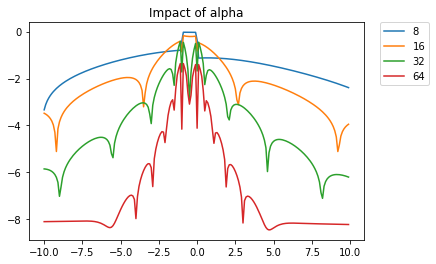

In [87]:
model = vgmodel
abscissae_list = [8, 16, 32, 64]
alphas = [-10 + i * 10 / 100 for i in range(200)]

for num_abscissae in abscissae_list:
    errors = [math.log(abs(cm_lewis_opt(model=vgmodel,strike=1.1, maturity=3.0/12.0, num_abscissae=num_abscissae, integration_bound=400.0, alpha=alpha) - vg_exact_price)) / math.log(10.0) for alpha in alphas]
    plt.plot(alphas, errors, label=str(num_abscissae))

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Impact of alpha")
plt.show()

In the second bullet you are asked to compare Carr-Madan's choice to Lewis' choice, and finally to the payoff-independent alpha. The latter by the way is equal to 23.2:

In [81]:
payoff_independent_alpha_VG(vgmodel, 1.1, 3.0/12.0)

23.209442525618385

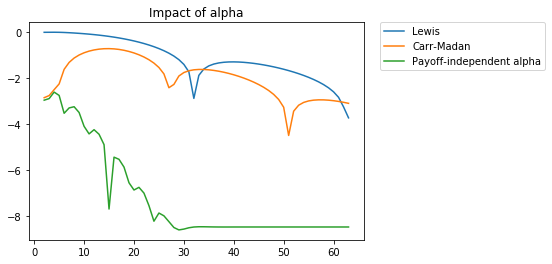

In [86]:
model = vgmodel
abscissae_list = range(2, 64)

error_func = lambda alpha: [math.log(abs(cm_lewis_opt(model=vgmodel,strike=1.1, maturity=3.0/12.0, num_abscissae=num_abscissae, integration_bound=400.0, alpha=alpha) - vg_exact_price)) / math.log(10.0) for num_abscissae in abscissae_list]

plt.plot(abscissae_list, error_func(-0.5), label='Lewis')
plt.plot(abscissae_list, error_func(0.75), label='Carr-Madan')
plt.plot(abscissae_list, error_func(payoff_independent_alpha_VG(vgmodel, 1.1, 3.0/12.0)), label='Payoff-independent alpha')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Impact of alpha")
plt.show()

As one can see - choosing the right contour really does pay off!